## D-Wave Error Correction: Forward and Reverse Annealing Together!?!?

In [10]:
# The Stanard Hodgepodge of Imports for Python
import qutip as qt
import qutip.states as qts
import qutip.operators as qto
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import seaborn as sns
from functools import reduce
from functools import partial
from scipy.stats import entropy as entropy
from itertools import chain

sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (nqubit_1pauli, nqubit_2pauli, loadAandB, dict_to_qutip,
                       make_numeric_schedule, get_numeric_H, time_interpolation)

### Before, we did a 3 qubit problem; let's try a 4 qubit problem.

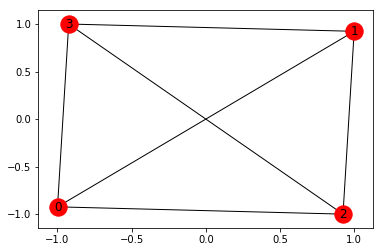

In [2]:
# First, let's create a sample 4 qubit Hamiltonian no h bias
H = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (3, 3): 0, (0, 1): 1, (1, 2): -1, (2, 3): 1, (0, 3): -1, (1, 3): 1, (0, 2): -1}
systot = DictRep(H = H, qpu = 'dwave', vartype = 'ising', encoding = 'logical')
graph = systot.visualize_graph()

In [15]:
systot.loadAandB()
states = systot.forward_anneal(20)

In [14]:
list(chain.from_iterable(chain.from_iterable(gs)))

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4999999999999999,
 0.0,
 0.0,
 0.4999999999999999,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

array([[3.91729694e-09]])

While this is the Logical Hamiltonian we would LIKE to solve, we are interested in breaking it up into subsystems we'll call A and B so that we can forward/ reverse anneal them in tandem. 

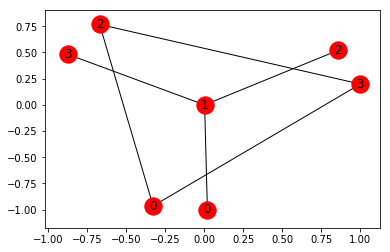

In [64]:
# This is H, minus the coupling that connects qubit 1 to qubit 2
HF = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (3, 3): 0, (0, 3): -1, (2, 3): 1, (0, 2): -1}
sysF = DictRep(HF, 'dwave', 'ising', 'logical')
# this only includes the coupling between qubits 1 and 2
HR = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (3, 3): 0, (0, 1): 1, (1, 2): -1, (1, 3): 1}
sysR = DictRep(HR, 'dwave', 'ising', 'logical')
graph1 = sysF.visualize_graph()
graph2 = sysR.visualize_graph()

Now, we will create three anneal schedules. The first will be used to perform a forward anneal on the total system. The other two will be to perform a forward/ reverse anneal on system A/B. 

In [65]:
T = 0.5
# total system anneal schedule
systot_schedule = make_numeric_schedule(.1, **{'direction': 'forward', 'ta': T})
systot_times, systot_svals = systot_schedule[0], systot_schedule[1]
# system A forward anneal (this is redundant but used to be pedantically clear)
sysF_schedule = make_numeric_schedule(.1, **{'direction': 'forward', 'ta': T})
sysF_times, sysF_svals = sysF_schedule[0], sysF_schedule[1]
# system B reverse anneal schedule
sysR_schedule = make_numeric_schedule(.1, **{'direction': 'reverse', 'ta': T/2, 'sa': 0.5, 'tq': T/2})
sysR_times, sysR_svals = sysR_schedule[0], sysR_schedule[1]

As the last pre-processing step, we will create the three separate numerical and list-based Hamiltonians to actually run the QuTip simulations on each three of the systems.

In [66]:
processor_data = loadAandB()
# Crearing the Hamiltonian for the ENTIRE system
systot_ABfuncs = time_interpolation(systot_schedule, processor_data)
systot_numericH = get_numeric_H(systot)
systot_A = systot_ABfuncs['A(t)']
systot_B = systot_ABfuncs['B(t)']
systot_HX = systot_numericH['HX']
systot_HZ = systot_numericH['HZ']
# "Analytic" or function H(t)
systot_H = lambda t : systot_A(t)*systot_HX + systot_B(t)*systot_HZ
# Define list_H for QuTiP
systot_listH = [[systot_HX, systot_A], [systot_HZ, systot_B]]

In [67]:
# Create the Hamiltonian for system A
sysF_ABfuncs = time_interpolation(sysF_schedule, processor_data)
sysF_numericH = get_numeric_H(sysF)
sysF_A = sysF_ABfuncs['A(t)']
sysF_B = sysF_ABfuncs['B(t)']
sysF_HX = sysF_numericH['HX']
sysF_HZ = sysF_numericH['HZ']
# "Analytic" or function H(t)
sysF_H = lambda t : sysF_A(t)*sysF_HX + sysF_B(t)*sysF_HZ
# Define list_H for QuTiP
sysF_listH = [[sysF_HX, sysF_A], [sysF_HZ, sysF_B]]

In [68]:
# Create the Hamiltonian for system B
sysR_ABfuncs = time_interpolation(sysR_schedule, processor_data)
sysR_numericH = get_numeric_H(sysR)
sysR_A = sysR_ABfuncs['A(t)']
sysR_B = sysR_ABfuncs['B(t)']
sysR_HX = sysR_numericH['HX']
sysR_HZ = sysR_numericH['HZ']
# "Analytic" or function H(t)
sysR_H = lambda t : sysR_A(t)*sysR_HX + sysR_B(t)*sysR_HZ
# Define list_H for QuTiP
sysR_listH = [[sysR_HX, sysR_A], [sysR_HZ, sysR_B]]

In [70]:
# Combine system A and system B Hamitlonian's into a single Hamiltonian and compare to sysT and 
# some time in the middle of the anneal and at the end
sysFR_listH = [[sysF_HX, sysF_A], [sysF_HZ, sysF_B], [sysR_HX, sysR_A], [sysR_HZ, sysR_B]]
sysFR_H = lambda t: sysF_H(t) + sysR_H(t)

# Actually Running the Numerical Anneals
## The Entire System
### First Up: Exact Diagonlization for Comparison

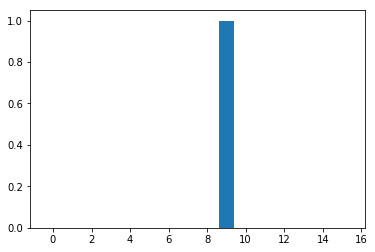

In [112]:
gs = gs_calculator(systot_H(T))
gs_amps = np.array([abs(gs[i])**2 for i in range(16)])
plt.bar([i for i in range(16)], gs_amps.flatten())
plt.show()

### Now Let's do a Numerical Anneal on the Entire System

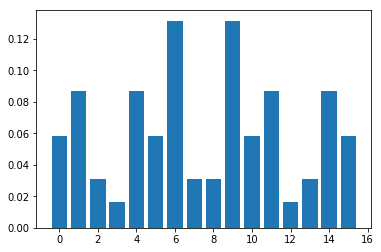

In [113]:
results = qt.sesolve(systot_listH, gs_calculator(systot_H(0)), systot_times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(16)])
plt.bar([i for i in range(16)], amps.flatten())
plt.show()

## Forward Anneal System A and Reverse Anneal System B
### First Up, Exact Diagalization

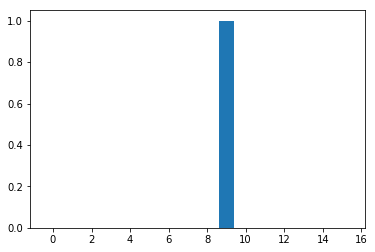

In [114]:
gs = gs_calculator(sysFR_H(T))
gs_amps = np.array([abs(gs[i])**2 for i in range(16)])
plt.bar([i for i in range(16)], gs_amps.flatten())
plt.show()

### Now for the Numerical Anneal of A and B in tandem
Here, the initial state is slightly more complicated than the ground-state of H(0) (the equal superposition state). Instead, sysA starts out in the initial superposition state whereas sysB starts out in some user-defined classical state. For this example, we'll just choose up-up for this. 

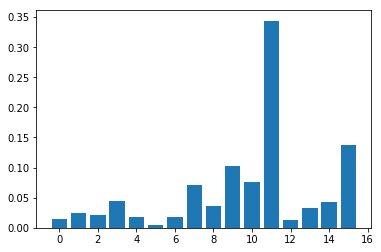

In [115]:
# q1 is the only qubit in system A in this example
q1init_state = (qts.ket([0])-qts.ket([1])).unit()
# q0, q2, and q3 are part of system B in this example
q0init_state = qts.ket([1])
q2init_state = qts.ket([1])
q3init_state = qts.ket([1])

# to combine the system state together, we need only take the tensor product
init_state = qt.tensor(q0init_state, q1init_state, q2init_state, q3init_state).unit()

# the actual numerical simulation
results = qt.sesolve(sysFR_listH, init_state, systot_times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(16)])
plt.bar([i for i in range(16)], amps.flatten())
plt.show()

In [116]:
def frem(H, HA, HB, T, s, HA_init_state, stepsize):
    # define the Hamiltonians
    systot = DictRep(H = H, qpu = 'dwave', vartype = 'ising', encoding = 'logical')
    sysA = DictRep(HA, 'dwave', 'ising', 'logical')
    sysB = DictRep(HB, 'dwave', 'ising', 'logical')
    
    # load up the data needed for anneal schedules
    processor_data = loadAandB()
    
    # define the anneal schedules
    # for the total system
    systot_schedule = make_numeric_schedule(stepsize, **{'direction': 'forward', 'ta': T})
    systot_times, systot_svals = systot_schedule[0], systot_schedule[1]
    # system A forward anneal (this is redundant but used to be pedantically clear)
    sysA_schedule = make_numeric_schedule(stepsize, **{'direction': 'forward', 'ta': T})
    sysA_times, sysA_svals = sysA_schedule[0], sysA_schedule[1]
    # system B reverse anneal schedule
    sysB_schedule = make_numeric_schedule(stepsize, **{'direction': 'reverse', 'ta': T/2, 'sa': 0.5, 'tq': T/2})
    sysB_times, sysB_svals = sysB_schedule[0], sysB_schedule[1]
    
    # Crearing the Hamiltonian for the ENTIRE system
    systot_ABfuncs = time_interpolation(systot_schedule, processor_data)
    systot_numericH = get_numeric_H(systot)
    systot_A = systot_ABfuncs['A(t)']
    systot_B = systot_ABfuncs['B(t)']
    systot_HX = systot_numericH['HX']
    systot_HZ = systot_numericH['HZ']
    # "Analytic" or function H(t)
    systot_H = lambda t : systot_A(t)*systot_HX + systot_B(t)*systot_HZ
    # Define list_H for QuTiP
    systot_listH = [[systot_HX, systot_A], [systot_HZ, systot_B]]
    
    # Create the Hamiltonian for system A
    sysA_ABfuncs = time_interpolation(sysA_schedule, processor_data)
    sysA_numericH = get_numeric_H(sysA)
    sysA_A = sysA_ABfuncs['A(t)']
    sysA_B = sysA_ABfuncs['B(t)']
    sysA_HX = sysA_numericH['HX']
    sysA_HZ = sysA_numericH['HZ']
    # "Analytic" or function H(t)
    sysA_H = lambda t : sysA_A(t)*sysA_HX + sysA_B(t)*sysA_HZ
    # Define list_H for QuTiP
    sysA_listH = [[sysA_HX, sysA_A], [sysA_HZ, sysA_B]]
    
    # Create the Hamiltonian for system B
    sysB_ABfuncs = time_interpolation(sysB_schedule, processor_data)
    sysB_numericH = get_numeric_H(sysB)
    sysB_A = sysB_ABfuncs['A(t)']
    sysB_B = sysB_ABfuncs['B(t)']
    sysB_HX = sysB_numericH['HX']
    sysB_HZ = sysB_numericH['HZ']
    # "Analytic" or function H(t)
    sysB_H = lambda t : sysB_A(t)*sysB_HX + sysB_B(t)*sysB_HZ
    # Define list_H for QuTiP
    sysB_listH = [[sysB_HX, sysB_A], [sysB_HZ, sysB_B]]
    
    # Combine system A and system B Hamitlonian's into a single Hamiltonian and compare to sysT and 
    # some time in the middle of the anneal and at the end
    sysAB_listH = [[sysA_HX, sysA_A], [sysA_HZ, sysA_B], [sysB_HX, sysB_A], [sysB_HZ, sysB_B]]
    sysAB_H = lambda t: sysA_H(t) + sysB_H(t)
    
    # diagonalize the final system Hamiltonian
    gs = gs_calculator(systot_H(T))
    gs_amps = np.array([abs(gs[i])**2 for i in range(16)])
    
    # perform a numerical forward anneal on the total system
    f_results = qt.sesolve(systot_listH, systot_H(0).groundstate()[1], systot_times)
    f_amps = np.array([abs(f_results.states[-1][i])**2 for i in range(16)])
    
    # make sure the initial state for HA is normalized
    HA_init_state = HA_init_state.unit()
    
    # q1 and q2 are part of system B in this example
    # NOTE: need to generalize this to include all qubits of HB
    # and in the correct order w.r.t. qubits in A
    q0init_state = qts.ket([1])
    q2init_state = qts.ket([1])
    q3init_state = qts.ket([1])

    # to combine the system state together, we need only take the tensor product
    init_state = qt.tensor(q0init_state, HA_init_state, q2init_state, q3init_state).unit()

    # the actual numerical simulation
    frem_results = qt.sesolve(sysAB_listH, init_state, systot_times)
    frem_amps = np.array([abs(frem_results.states[-1][i])**2 for i in range(16)])
    
    KL_f_wrt_diag = entropy(f_amps, gs_amps)
    print("Kullback-Liebler of forward anneal w.r.t. diagonlaization: {}".format(KL_f_wrt_diag))
    KL_frem_wrt_diag = entropy(frem_amps, gs_amps)
    print("Kullback-Liebler of frem anneal w.r.t. diagonlization: {}".format(KL_frem_wrt_diag))
    
    states = np.linspace(0, 15, 16)
    ax = plt.subplot(111)
    ax.bar(states-0.2, gs_amps.flatten(),width=0.2,color='b',align='center',label='diag')
    ax.bar(states, f_amps.flatten(),width=0.2,color='g',align='center', label='forward')
    ax.bar(states+0.2, frem_amps.flatten(),width=0.2,color='r',align='center', label='frem')
    plt.legend()
    
    return [ax]

In [117]:
frem_tests = partial(frem, H=H, HA=HF, HB=HR, stepsize=0.1)

Kullback-Liebler of forward anneal w.r.t. diagonlaization: [[inf]]
Kullback-Liebler of frem anneal w.r.t. diagonlization: [[inf]]


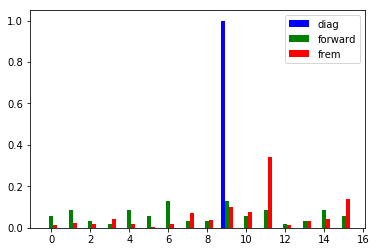

In [118]:
frem_tests(T = .5, s = 0.1, HA_init_state=(qts.ket([0]) - qts.ket([1])).unit())
plt.show()

## Things to Fix/ Add/ Consider 
1) Don't forget to also do a standard reverse anneal with a "similar" starting state and same s value; in particular, choose a "random" initial classical state; it might also be worth trying a super-position state?

2) Fix the ground-state finding function to be more general (cost in speed, of course).

3) Allow function to take in starting states of HF rather than HF--which is fixed as down in x-basis. 

4) Are there good heuristics to partition the Hamiltonian up? 

5) If so, how much partitioning should be allowed?

In [98]:
def gs_calculator(H, etol=1e-8, stol=1e-12):
    """
    Computes the (possibly degenerate) ground state of an input
    Hamiltonian H. 
    
    H: a QuTIP defined Hamitltonian
    gs: ground-state in QuTIP style
    """
    energies, states = H.eigenstates()
    degeneracy = 1
    lowest_E = energies[0]
    for n in range(1,len(energies)):
        if abs(energies[n]-lowest_E) < etol:
            degeneracy += 1
            
    gs = states[0]
    for n in range(1, degeneracy):
        gs = gs + states[n]
    #gs = gs.tidyup(stol)
    gs = gs.unit()
    
    return gs        

In [89]:
energies, states = systot_H(T).eigenstates()

In [90]:
print((states[0] + states[1]).unit())

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 1.40512093e-07]
 [-1.11473415e-09]
 [ 0.00000000e+00]
 [-3.34420277e-09]
 [ 0.00000000e+00]
 [ 2.37933664e-02]
 [-1.11473414e-09]
 [ 4.68373641e-08]
 [-9.99716898e-01]
 [ 0.00000000e+00]
 [ 1.40512093e-07]
 [ 0.00000000e+00]
 [ 4.68373641e-08]
 [-3.34420212e-09]
 [ 0.00000000e+00]]


In [109]:
(-9.99716898e-01)**2

0.9994338761467423